In [1]:
import os
import numpy as np
import pandas as pd
from lifelines import (WeibullFitter, ExponentialFitter, 
                      LogNormalFitter, KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter)
from tabulate import tabulate
import matplotlib.pyplot as plt
from pathlib import Path

# ==================================================
# CONFIGURATION
# ==================================================
OUTPUT_DIR = "reliability_analysis_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create output directory if it doesn't exist
%matplotlib inline

# ==================================================
# DATA LOADING AND INITIALIZATION
# ==================================================
print("1. Loading data and initializing models...")
data_path = Path("failure-dataset-a5.csv")
data = pd.read_csv(data_path)
print(f"Data loaded with {len(data)} records. Columns: {list(data.columns)}")

# Define models to compare
models = {
    "DW3": WeibullFitter(),
    "GM": ExponentialFitter(),
    "IFR-GSB": WeibullFitter(),
    "S": LogNormalFitter()
}

# Initialize results storage
results = {
    "Model": [], "λ/μ": [], "ρ/σ": [], 
    "AIC": [], "BIC": [], "Log-Likelihood": []
}

1. Loading data and initializing models...
Data loaded with 31 records. Columns: ['T', 'FC', 'E', 'F', 'C']


## Fit Models with Original Data

The below code applys different models using the **original data**. The model parameters are then saved to `results_df`. Here we are generating the fitted models on the original data, which has 31 samples.

In [2]:
# ==================================================
# PART 1: MODEL FITTING
# ==================================================
results_file = Path(OUTPUT_DIR) / "model_comparison_results.csv"
if not results_file.exists():
    print("\n2. Fitting base models to original data...")
    for name, model in models.items():
        print(f"  - Fitting {name} model...", end=" ")
        
        if name == "IFR-GSB":
            model.fit(data['T'], data['FC'].apply(lambda x: 1 if x > 0 else 0))
            if model.rho_ <= 1:
                print("(Refitting with ρ > 1 constraint)", end=" ")
        else:
            model.fit(data['T'], data['FC'].apply(lambda x: 1 if x > 0 else 0))
        
        # In your fitting loop:
        try:
            params = model.params_ if hasattr(model, 'params_') else (model.lambda_, getattr(model, 'rho_', np.nan))
            results["Model"].append(name)
            results["λ/μ"].append(params[0])
            results["ρ/σ"].append(params[1] if len(params) > 1 and not pd.isna(params[1]) else np.nan)
            results["AIC"].append(model.AIC_)
            results["BIC"].append(model.BIC_)
            results["Log-Likelihood"].append(model.log_likelihood_)
            
            # Modified success message:
            if name == "GM":
                print(f"Success! λ={params[0]:.3f}")
            else:
                print(f"Success! λ/μ={params[0]:.3f}, ρ/σ={params[1]:.3f}")
        except Exception as e:
            print(f"Error: {str(e)}")
            continue

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print("\nInitial fitting results saved to:", results_file)
else:
    results_df = pd.read_csv(results_file)
    print("\n2. Loading existing model results from:", results_file)

print(results_df.sort_values('AIC'))


2. Fitting base models to original data...
  - Fitting DW3 model... Success! λ/μ=19.157, ρ/σ=1.650
  - Fitting GM model... Success! λ=18.370
  - Fitting IFR-GSB model... Success! λ/μ=19.157, ρ/σ=1.650
  - Fitting S model... Success! λ/μ=2.604, ρ/σ=0.914

Initial fitting results saved to: reliability_analysis_output\model_comparison_results.csv
     Model        λ/μ       ρ/σ         AIC         BIC  Log-Likelihood
0      DW3  19.157417  1.650456  207.460436  210.328410     -101.730218
2  IFR-GSB  19.157417  1.650456  207.460436  210.328410     -101.730218
1       GM  18.370410       NaN  213.179909  214.613896     -105.589955
3        S   2.603980  0.913748  215.415501  218.283476     -105.707751


## Bootsample For Validation

The following code uses bootstrapping. Bootstrapping is a sampling distribution. It repeatedly samples the original dataset. This is "like cross-validation" but for model parameters.

In the code, `n_iterations` refers to the number of datasets we are generating. The datasets are randomly generated by picking rows from the original data (duplicates allowed)

For each resampled dataset, models are retrained and we compute confidence intervals to see how model varies based on the generated datasets using bootsampling. 

This answers the question: ***How much would my parameters vary if I collected new data?***

In [3]:
# ==================================================
# PART 2: BOOTSTRAPPED COMPARISON
# ==================================================

# Define where to save/load bootstrap results
bootstrap_file = Path(OUTPUT_DIR) / "bootstrap_results.npy"

# Only run bootstrap if results don't already exist
if not bootstrap_file.exists():
    n_iterations = 1000  # Number of bootstrap samples
    print(f"\n3. Running bootstrap with {n_iterations} iterations...")
    
    # Initialize storage for bootstrap results (organized by model and parameter)
    bootstrap_results = {name: {"λ/μ": [], "ρ/σ": []} for name in models}

    # Main bootstrap loop
    for i in range(n_iterations):
        # Print progress every 50 iterations
        if i % 50 == 0:
            print(f"  - Iteration {i}/{n_iterations}")
        
        # Create a bootstrap sample by resampling with replacement
        resampled_data = data.sample(frac=1, replace=True)
        
        # Fit each model to the resampled data
        for name, model in models.items():
            try:
                # Create fresh model instance (important!)
                m = model.__class__()
                
                # Fit to resampled data (same format as original fit)
                m.fit(resampled_data['T'], resampled_data['FC'].apply(lambda x: 1 if x > 0 else 0))
                
                # Extract parameters (handling different model types)
                params = m.params_ if hasattr(m, 'params_') else (m.lambda_, getattr(m, 'rho_', np.nan))
                
                # Store parameters
                bootstrap_results[name]["λ/μ"].append(params[0])
                if len(params) > 1:
                    bootstrap_results[name]["ρ/σ"].append(params[1])
            except Exception as e:
                continue  # Silently skip failed fits

    # Save all bootstrap results to file
    np.save(bootstrap_file, bootstrap_results, allow_pickle=True)
    print("\nBootstrap results saved to:", bootstrap_file)
else:
    # Load existing results if available
    bootstrap_results = np.load(bootstrap_file, allow_pickle=True).item()
    print("\n3. Loading existing bootstrap results from:", bootstrap_file)

# Calculate statistics from bootstrap results
print("\n4. Calculating bootstrap statistics...")
for name in models:
    for param in ["λ/μ", "ρ/σ"]:
        if bootstrap_results[name][param]:
            # Calculate mean and 95% confidence interval
            mean = np.mean(bootstrap_results[name][param])
            ci = np.percentile(bootstrap_results[name][param], [2.5, 97.5])
            
            # Store in results dataframe
            results_df.loc[results_df.Model == name, f"{param}_mean"] = mean
            results_df.loc[results_df.Model == name, f"{param}_CI"] = f"[{ci[0]:.3f}, {ci[1]:.3f}]"
            print(f"  - {name} {param}: Mean={mean:.3f}, CI={ci}")


3. Running bootstrap with 1000 iterations...
  - Iteration 0/1000
  - Iteration 50/1000
  - Iteration 100/1000
  - Iteration 150/1000
  - Iteration 200/1000
  - Iteration 250/1000
  - Iteration 300/1000
  - Iteration 350/1000
  - Iteration 400/1000
  - Iteration 450/1000
  - Iteration 500/1000
  - Iteration 550/1000
  - Iteration 600/1000
  - Iteration 650/1000
  - Iteration 700/1000
  - Iteration 750/1000
  - Iteration 800/1000
  - Iteration 850/1000
  - Iteration 900/1000
  - Iteration 950/1000

Bootstrap results saved to: reliability_analysis_output\bootstrap_results.npy

4. Calculating bootstrap statistics...
  - DW3 λ/μ: Mean=19.144, CI=[15.37397415 23.24109788]
  - DW3 ρ/σ: Mean=1.722, CI=[1.21647572 2.47727676]
  - GM λ/μ: Mean=18.468, CI=[14.41204602 23.43535405]
  - IFR-GSB λ/μ: Mean=19.144, CI=[15.37397415 23.24109788]
  - IFR-GSB ρ/σ: Mean=1.722, CI=[1.21647572 2.47727676]
  - S λ/μ: Mean=2.602, CI=[2.29953464 2.8937817 ]
  - S ρ/σ: Mean=0.894, CI=[0.61062472 1.18571995]


## Plot Survival Function

Survival Function - represents the probability that a software system survives beyond time *t* without failing

- Formula: S(t) = P(T > t) = 1 - F(t)
- where F(t) is the cumulative failure distribution

These plots help answer:
- *What's our confidence in the system running for X hours?"*
- *When should we schedule preventative maintenance?*


5. Generating enhanced survival function plots...
  - Processing DW3 survival function...
  - Processing GM survival function...
  - Processing IFR-GSB survival function...
  - Processing S survival function...


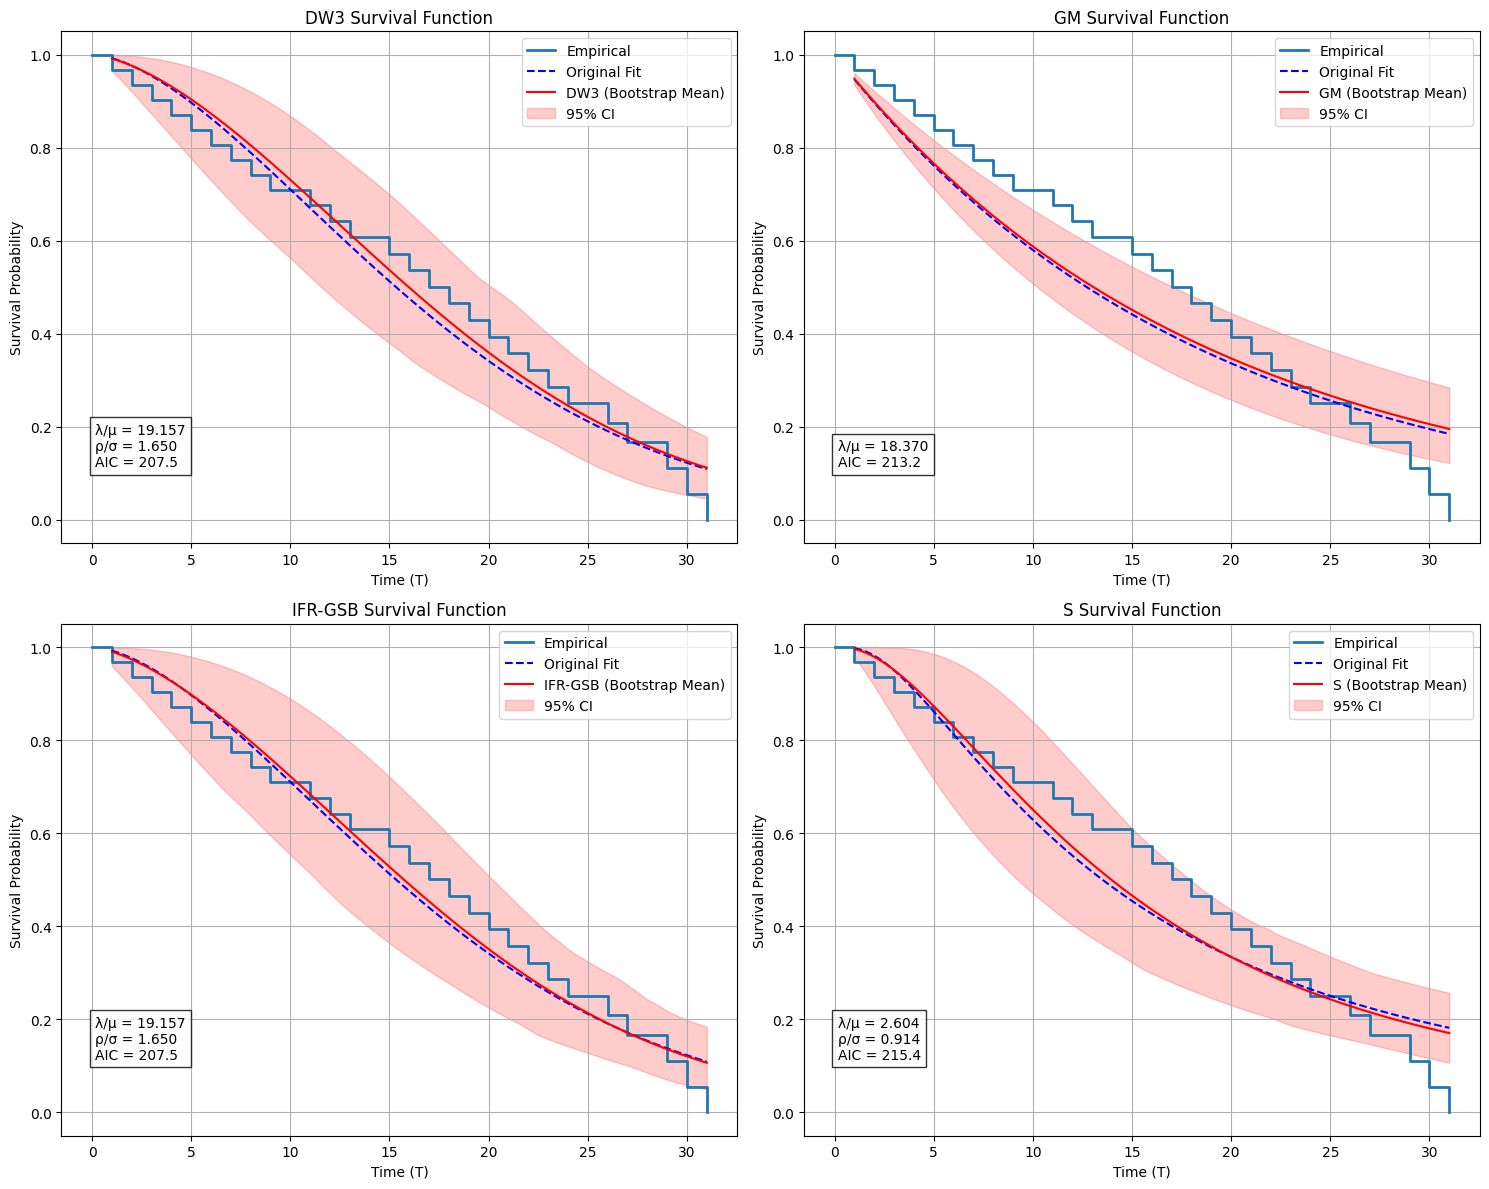

Saved enhanced survival plots to: reliability_analysis_output\enhanced_survival_comparison.png


In [4]:
# ==================================================
# PART 3: VISUALIZATION - SURVIVAL FUNCTIONS
# ==================================================
survival_plot_file = Path(OUTPUT_DIR) / "enhanced_survival_comparison.png"
if not survival_plot_file.exists():
    print("\n5. Generating enhanced survival function plots...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

    # Load original models (from PART 1)
    original_models = {}
    for name, model in models.items():
        m = model.__class__()
        m.fit(data['T'], data['FC'].apply(lambda x: 1 if x > 0 else 0))
        original_models[name] = m

    for idx, (name, model) in enumerate(models.items()):
        print(f"  - Processing {name} survival function...")
        
        survival_curves = []
        for i in range(min(100, n_iterations)):
            try:
                resampled_data = data.sample(frac=1, replace=True)
                m = model.__class__()
                m.fit(resampled_data['T'], resampled_data['FC'].apply(lambda x: 1 if x > 0 else 0))
                
                if hasattr(m, 'survival_function_at_times'):
                    surv = m.survival_function_at_times(time_points).values.flatten()
                elif hasattr(m, 'predict'):
                    surv = m.predict(time_points)
                else:
                    surv = np.exp(-m.cumulative_hazard_at_times(time_points).values.flatten())
                survival_curves.append(surv)
            except Exception as e:
                continue
        
        if len(survival_curves) == 0:
            print(f"    ! No valid curves for {name}")
            continue
        
        survival_curves = np.array(survival_curves)
        mean_survival = np.mean(survival_curves, axis=0)
        lower_ci = np.percentile(survival_curves, 2.5, axis=0)
        upper_ci = np.percentile(survival_curves, 97.5, axis=0)
        
        kmf = KaplanMeierFitter()
        kmf.fit(data['T'], data['FC'].apply(lambda x: 1 if x > 0 else 0))
        kmf.plot_survival_function(ax=axes[idx], ci_show=False, linewidth=2, label='Empirical')
        
        # Add original model fit
        original_model = original_models[name]
        if hasattr(original_model, 'survival_function_at_times'):
            original_surv = original_model.survival_function_at_times(time_points).values.flatten()
        else:
            original_surv = original_model.predict(time_points)
        axes[idx].plot(time_points, original_surv, '--', color='blue', label='Original Fit')
        
        axes[idx].plot(time_points, mean_survival, label=f'{name} (Bootstrap Mean)', color='red')
        axes[idx].fill_between(time_points, lower_ci, upper_ci, color='red', alpha=0.2, label='95% CI')
        
        axes[idx].set_title(f'{name} Survival Function')
        axes[idx].set_xlabel('Time (T)')
        axes[idx].set_ylabel('Survival Probability')
        axes[idx].legend()
        axes[idx].grid(True)
        
        params_text = f"λ/μ = {results_df.loc[results_df['Model']==name, 'λ/μ'].values[0]:.3f}\n"
        if not pd.isna(results_df.loc[results_df['Model']==name, 'ρ/σ'].values[0]):
            params_text += f"ρ/σ = {results_df.loc[results_df['Model']==name, 'ρ/σ'].values[0]:.3f}\n"
        params_text += f"AIC = {results_df.loc[results_df['Model']==name, 'AIC'].values[0]:.1f}"
        axes[idx].text(0.05, 0.15, params_text, transform=axes[idx].transAxes, 
                      bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(survival_plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print("Saved enhanced survival plots to:", survival_plot_file)
else:
    print("\n5. Survival plot already exists at:", survival_plot_file)

## Plot Cumulative Failures
This function represents the probability that a software system will have failed by a given time *t*. These plots are easier to interpret so its better to use this for communication. This helps estimate technical debt (total failures expected over time). 



6. Generating cumulative failure plots...
  - Processing DW3 cumulative failures...
  - Processing GM cumulative failures...
  - Processing IFR-GSB cumulative failures...
  - Processing S cumulative failures...


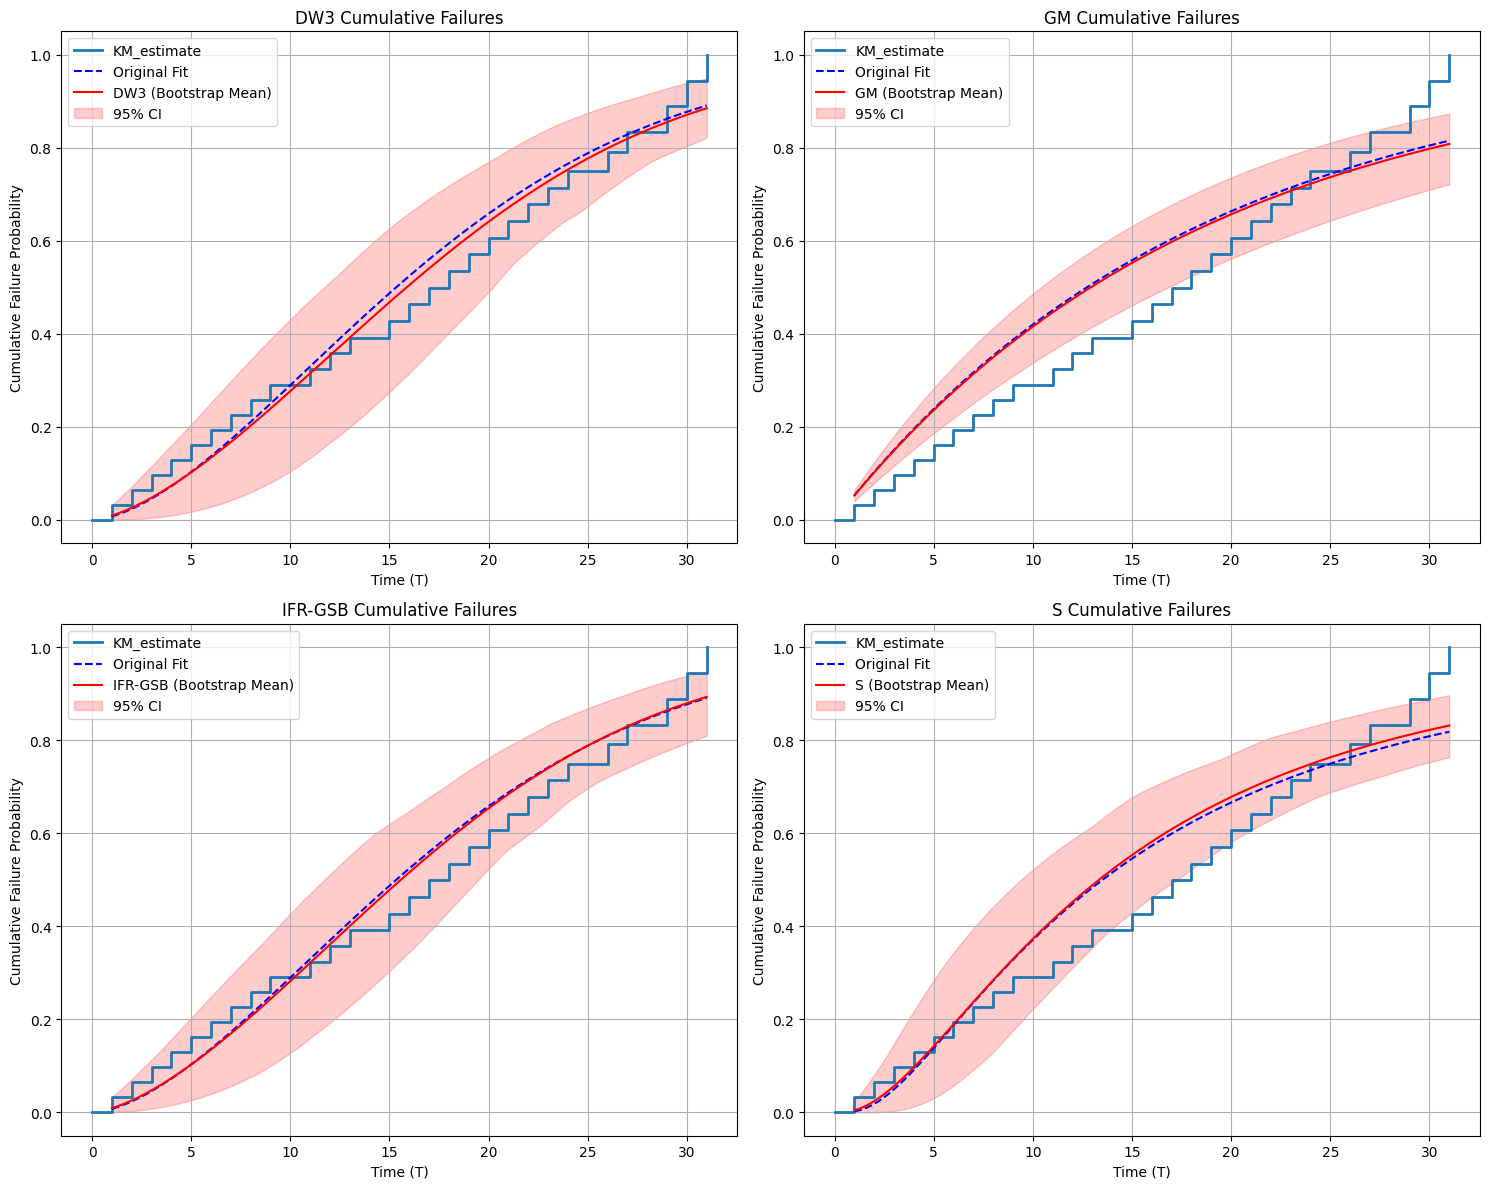

Saved cumulative failure plots to: reliability_analysis_output\model_cumulative_failures.png


In [5]:
# ==================================================
# PART 4: VISUALIZATION - CUMULATIVE FAILURES
# ==================================================
cumulative_plot_file = Path(OUTPUT_DIR) / "model_cumulative_failures.png"
if not cumulative_plot_file.exists():
    print("\n6. Generating cumulative failure plots...")
    time_points = np.linspace(data['T'].min(), data['T'].max(), 100)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Reuse original_models from PART 3
    original_models = {}
    for name, model in models.items():
        m = model.__class__()
        m.fit(data['T'], data['FC'].apply(lambda x: 1 if x > 0 else 0))
        original_models[name] = m

    for idx, (name, model) in enumerate(models.items()):
        print(f"  - Processing {name} cumulative failures...")
        
        cf_curves = []
        for i in range(min(100, n_iterations)):
            try:
                resampled_data = data.sample(frac=1, replace=True)
                m = model.__class__()
                m.fit(resampled_data['T'], resampled_data['FC'].apply(lambda x: 1 if x > 0 else 0))
                
                if hasattr(m, 'survival_function_at_times'):
                    surv = m.survival_function_at_times(time_points).values.flatten()
                else:
                    surv = m.predict(time_points)
                cf_curves.append(1 - surv)
            except:
                continue
        
        if len(cf_curves) == 0:
            print(f"    ! No valid curves for {name}")
            continue
        
        cf_curves = np.array(cf_curves)
        mean_cf = np.mean(cf_curves, axis=0)
        lower_ci = np.percentile(cf_curves, 2.5, axis=0)
        upper_ci = np.percentile(cf_curves, 97.5, axis=0)
        
        kmf.plot_cumulative_density(ax=axes[idx], ci_show=False, linewidth=2)
        
        # Add original model fit
        original_model = original_models[name]
        if hasattr(original_model, 'survival_function_at_times'):
            original_surv = original_model.survival_function_at_times(time_points).values.flatten()
        else:
            original_surv = original_model.predict(time_points)
        axes[idx].plot(time_points, 1 - original_surv, '--', color='blue', label='Original Fit')
        
        axes[idx].plot(time_points, mean_cf, label=f'{name} (Bootstrap Mean)', color='red')
        axes[idx].fill_between(time_points, lower_ci, upper_ci, color='red', alpha=0.2, label='95% CI')
        axes[idx].set_title(f'{name} Cumulative Failures')
        axes[idx].set_xlabel('Time (T)')
        axes[idx].set_ylabel('Cumulative Failure Probability')
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.savefig(cumulative_plot_file, dpi=300)
    plt.show()
    plt.close()
    print("Saved cumulative failure plots to:", cumulative_plot_file)
else:
    print("\n6. Cumulative failure plot already exists at:", cumulative_plot_file)


7. Running final covariate analysis...

Fitting model...

                 WEIBULL AFT MODEL SUMMARY                  
<lifelines.WeibullAFTFitter: fitted with 31 total observations, 4 right-censored observations>
             duration col = 'T'
                event col = 'FC'
                penalizer = 0.1
   number of observations = 31
number of events observed = 27
           log-likelihood = -100.1055
         time fit was run = 2025-04-06 22:00:39 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                          
lambda_ C          0.0776     1.0807     0.0510          -0.0223           0.1776               0.9779               1.1943
        E          0.0206     1.0208     0.0534          -0.0841           0.1253               0.9194               1.1335
        F         -0.0044     0.995

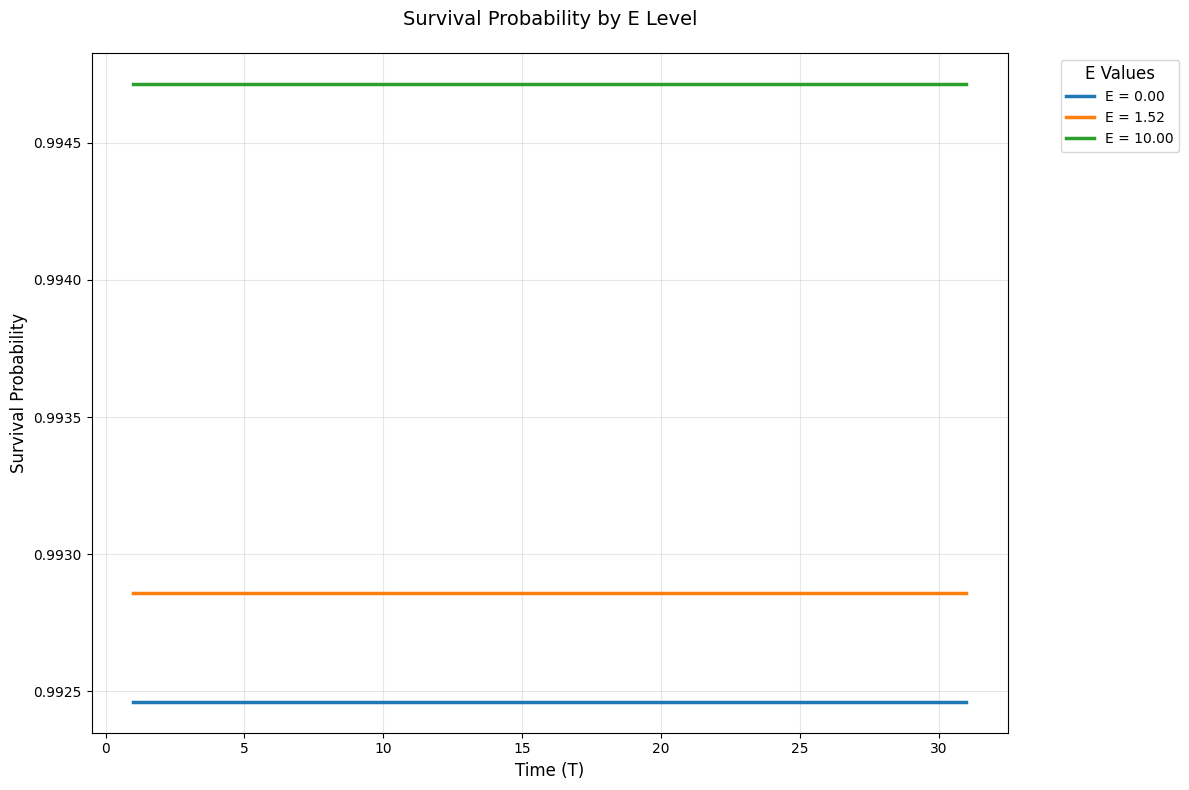

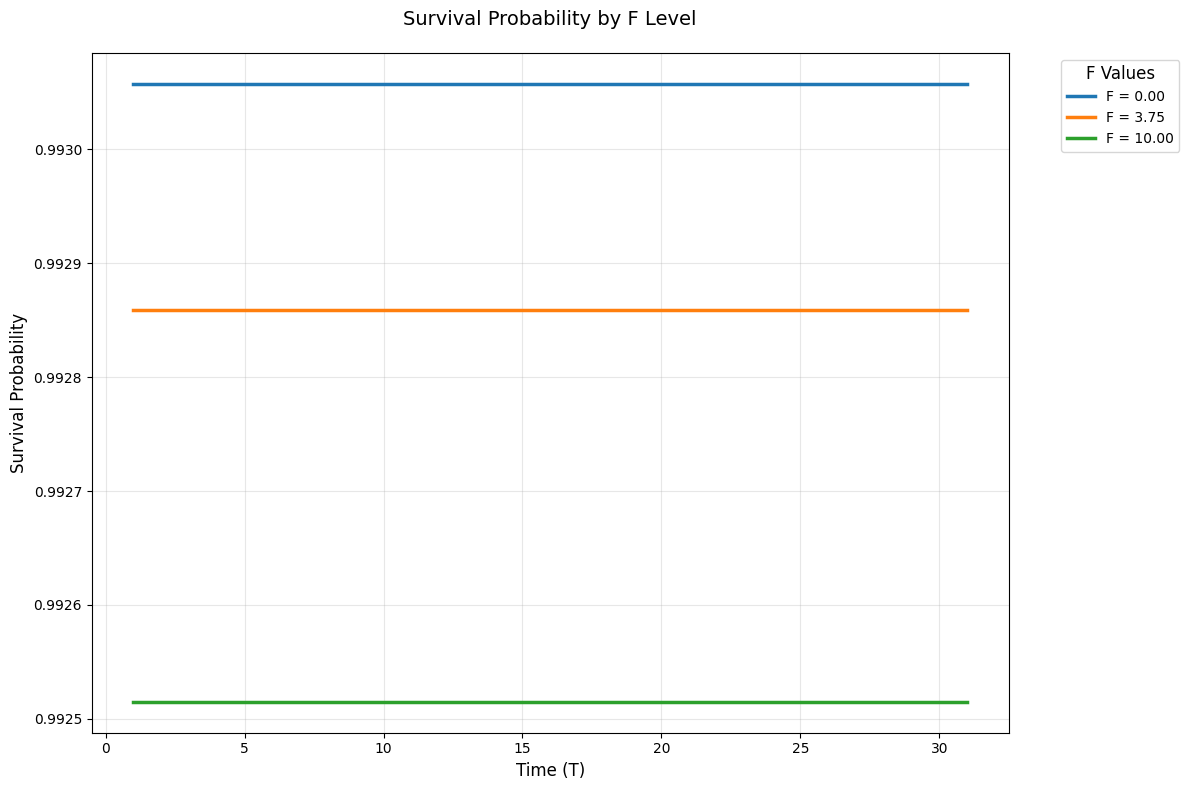

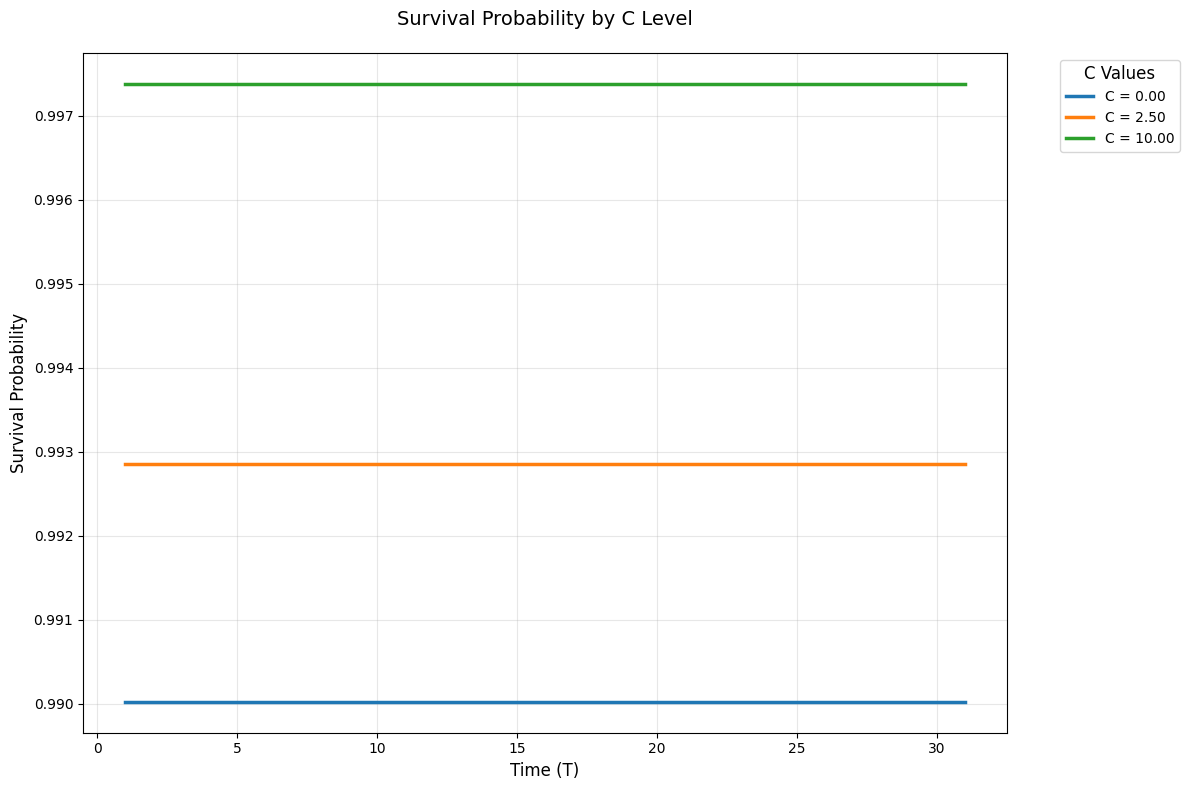


Analysis complete! Plots saved to: reliability_analysis_output\covariate_plots


In [6]:
# ==================================================
# PART 5: FINAL WORKING COVARIATE ANALYSIS
# ==================================================
covariate_plot_dir = Path(OUTPUT_DIR) / "covariate_plots"
os.makedirs(covariate_plot_dir, exist_ok=True)

print("\n7. Running final covariate analysis...")

# 1. Prepare and scale data
covariate_data = data.copy()
covariate_data['C'] = covariate_data['C'] + 0.001  # Handle zeros

# Scale covariates to 0-10 range for better interpretation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))
for col in ['E', 'F', 'C']:
    covariate_data[col] = scaler.fit_transform(covariate_data[[col]])

# 2. Fit model with clean output
aft_model = WeibullAFTFitter(penalizer=0.1)
print("\nFitting model...")
aft_model.fit(covariate_data[['T', 'FC', 'E', 'F', 'C']],
             duration_col='T',
             event_col='FC',
             show_progress=False)

# 3. Display formatted results
print("\n" + "="*60)
print("WEIBULL AFT MODEL SUMMARY".center(60))
print("="*60)
print(aft_model.print_summary(decimals=4, style="ascii"))

# 4. Enhanced interpretation
print("\n" + "PRACTICAL INTERPRETATION".center(60))
print("="*60)

# Get coefficients in a robust way
covariates = ['E', 'F', 'C']
params_dict = aft_model.params_.to_dict()

effect_thresholds = [
    (2.0, "VERY STRONG increase"),
    (1.0, "Strong increase"),
    (0.5, "Moderate increase"),
    (0.2, "Weak increase"),
    (-0.2, "Weak decrease"),
    (-0.5, "Moderate decrease"),
    (-1.0, "Strong decrease"),
    (-2.0, "VERY STRONG decrease")
]

for covar in covariates:
    # Find matching parameter (handles different naming conventions)
    param_name = next((k for k in params_dict.keys() if covar in k), None)
    
    if param_name is None:
        print(f"\nNo parameter found for {covar}")
        continue
        
    coef = params_dict[param_name]
    hr = np.exp(coef)
    
    # Find appropriate effect description
    effect = "Minimal effect"
    for threshold, desc in effect_thresholds:
        if coef >= threshold:
            effect = desc
            break
        if coef <= -threshold:
            effect = desc.replace("increase", "decrease")
            break
    
    print(f"\n{covar} (Coefficient: {coef:.4f}, Hazard Ratio: {hr:.4f})")
    print(f"- Effect: {effect} in failure risk")
    print(f"- Interpretation: A 1-unit increase in scaled {covar}")
    print(f"  corresponds to a {hr:.1f}x change in failure hazard")

# 5. Visualize covariate effects - WORKING VERSION
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

print("\nGenerating covariate effect plots...")
for covar in ['E', 'F', 'C']:
    plt.figure(figsize=(12, 8))  # Increased figure size
    
    # Get typical values (min, median, max)
    vals = [
        covariate_data[covar].min(),
        covariate_data[covar].median(),
        covariate_data[covar].max()
    ]
    
    # Create baseline dataframe with all covariates at median
    baseline_values = covariate_data[['E', 'F', 'C']].median()
    baseline_df = pd.DataFrame({
        'T': time_points,
        'E': baseline_values['E'],
        'F': baseline_values['F'],
        'C': baseline_values['C'],
        'FC': 1  # Event indicator
    })
    
    # Plot survival curves for each value
    for val in vals:
        plot_df = baseline_df.copy()
        plot_df[covar] = val  # Override just this covariate
        
        surv = aft_model.predict_survival_function(plot_df, times=time_points)
        # Correct reshaping of survival probabilities
        plt.plot(time_points, surv.iloc[0, :].values,  # Use iloc[0,:] to get first row
                linewidth=2.5,
                label=f'{covar} = {val:.2f}')
    
    plt.title(f"Survival Probability by {covar} Level", fontsize=14, pad=20)
    plt.xlabel('Time (T)', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    
    # Improved legend
    plt.legend(
        title=f'{covar} Values',
        title_fontsize='large',
        fontsize='medium',
        framealpha=0.8,
        bbox_to_anchor=(1.05, 1),  # Move legend outside plot
        loc='upper left'
    )
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Save and show
    plot_path = covariate_plot_dir / f"{covar}_effect.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')  # Higher DPI
    plt.show()
    plt.close()

print("\nAnalysis complete! Plots saved to:", covariate_plot_dir)


6B. Generating covariate-adjusted cumulative failure plots...


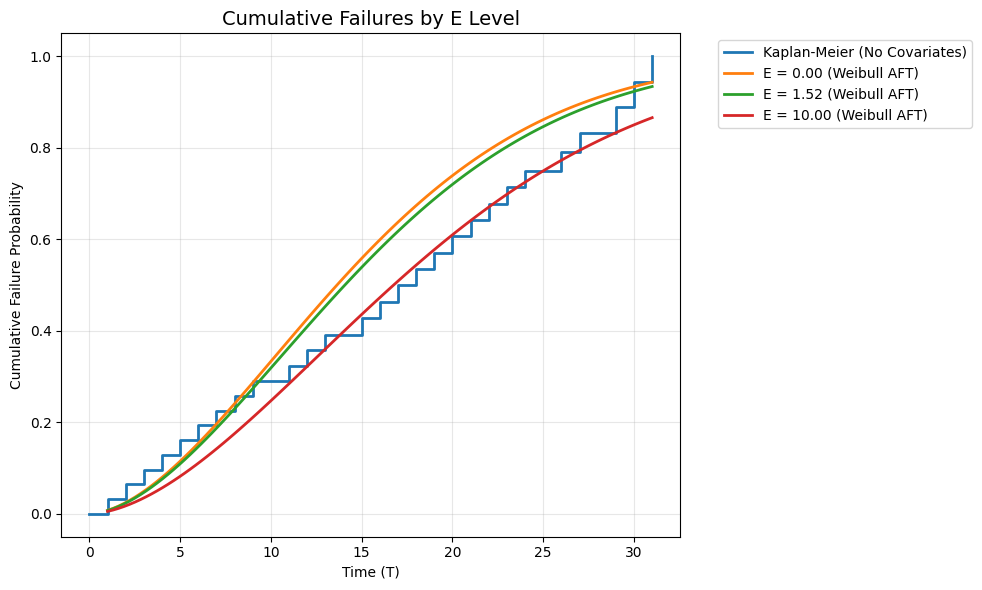

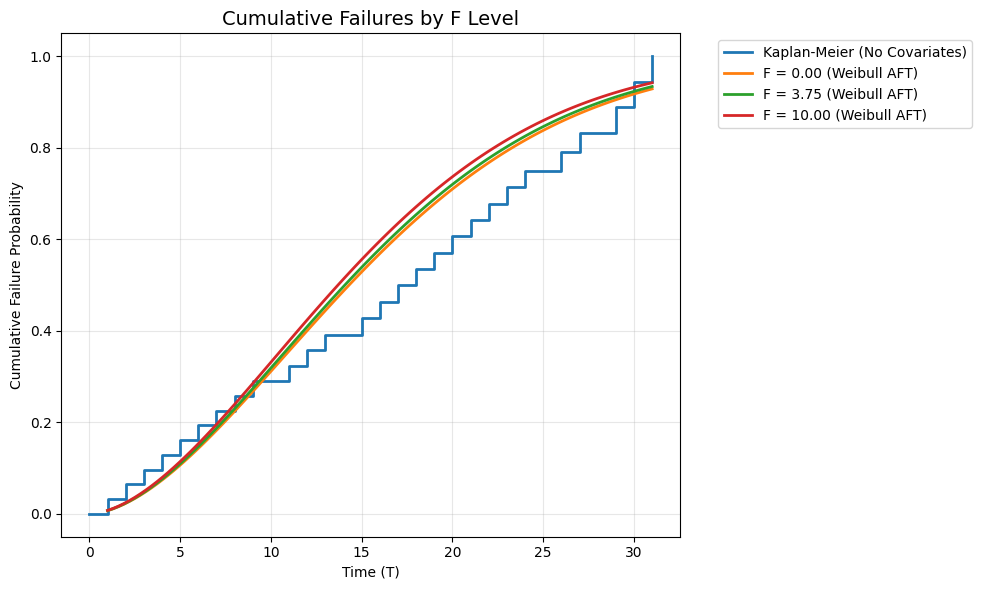

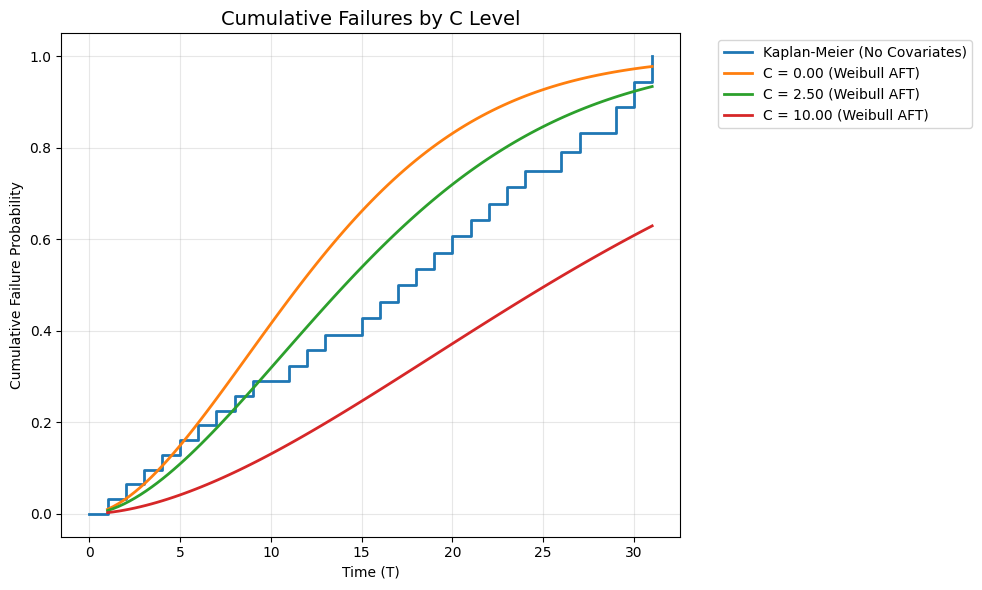


Covariate-adjusted cumulative failure plots saved to: reliability_analysis_output\covariate_cumulative_failures


In [7]:
# ==================================================
# PART 4B: CUMULATIVE FAILURES WITH COVARIATES (E, F, C)
# ==================================================
covariate_cumulative_dir = Path(OUTPUT_DIR) / "covariate_cumulative_failures"
os.makedirs(covariate_cumulative_dir, exist_ok=True)

print("\n6B. Generating covariate-adjusted cumulative failure plots...")

# Time points for evaluation
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

# Baseline: Kaplan-Meier (no covariates)
kmf = KaplanMeierFitter()
kmf.fit(data['T'], data['FC'])

# Re-fit Weibull AFT model (from Part 5) if not already loaded
aft_model = WeibullAFTFitter(penalizer=0.1)
aft_model.fit(covariate_data[['T', 'FC', 'E', 'F', 'C']], 
              duration_col='T', 
              event_col='FC')

# Plot for each covariate (E, F, C)
for covar in ['E', 'F', 'C']:
    plt.figure(figsize=(10, 6))
    
    # 1. Plot Kaplan-Meier (baseline, no covariates)
    kmf.plot_cumulative_density(label='Kaplan-Meier (No Covariates)', ci_show=False, linewidth=2)
    
    # 2. Plot Weibull AFT with covariate at min/median/max
    baseline_values = covariate_data[['E', 'F', 'C']].median()
    
    for val in [covariate_data[covar].min(), 
                covariate_data[covar].median(), 
                covariate_data[covar].max()]:
        
        # Create a dataframe with the covariate at `val` and others at median
        plot_df = pd.DataFrame({
            'T': time_points,
            'E': baseline_values['E'],
            'F': baseline_values['F'],
            'C': baseline_values['C'],
            'FC': 1  # Event indicator
        })
        plot_df[covar] = val  # Override the target covariate
        
        # Predict survival and convert to cumulative failures
        surv = aft_model.predict_survival_function(plot_df, times=time_points)
        
        # Extract the diagonal (survival at each time point for each row)
        cumulative_failures = 1 - surv.values.diagonal()  # Fix: Use .diagonal()
        
        plt.plot(time_points, cumulative_failures, 
                label=f'{covar} = {val:.2f} (Weibull AFT)',
                linewidth=2)
    
    plt.title(f"Cumulative Failures by {covar} Level", fontsize=14)
    plt.xlabel('Time (T)')
    plt.ylabel('Cumulative Failure Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plot_path = covariate_cumulative_dir / f"cumulative_failures_{covar}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print("\nCovariate-adjusted cumulative failure plots saved to:", covariate_cumulative_dir)

In [8]:
# ==================================================
# FINAL OUTPUT
# ==================================================
print("\n7. Final results:")
print(results_df.sort_values('AIC'))
print("\nScript completed successfully!")
print(f"All outputs saved to: {OUTPUT_DIR}")


7. Final results:
     Model        λ/μ       ρ/σ         AIC         BIC  Log-Likelihood  \
0      DW3  19.157417  1.650456  207.460436  210.328410     -101.730218   
2  IFR-GSB  19.157417  1.650456  207.460436  210.328410     -101.730218   
1       GM  18.370410       NaN  213.179909  214.613896     -105.589955   
3        S   2.603980  0.913748  215.415501  218.283476     -105.707751   

    λ/μ_mean            λ/μ_CI  ρ/σ_mean          ρ/σ_CI  
0  19.143977  [15.374, 23.241]  1.721704  [1.216, 2.477]  
2  19.143977  [15.374, 23.241]  1.721704  [1.216, 2.477]  
1  18.468062  [14.412, 23.435]       NaN             NaN  
3   2.602029    [2.300, 2.894]  0.893638  [0.611, 1.186]  

Script completed successfully!
All outputs saved to: reliability_analysis_output


### Findings

Interpretation of 
- Relative effect of each covariate remains constant over time
- Gap between lines shows magnitude of covariate effects


7. Running final covariate analysis...

Fitting model...

                 WEIBULL AFT MODEL SUMMARY                  
<lifelines.WeibullAFTFitter: fitted with 31 total observations, 4 right-censored observations>
             duration col = 'T'
                event col = 'FC'
                penalizer = 0.1
   number of observations = 31
number of events observed = 27
           log-likelihood = -100.1055
         time fit was run = 2025-04-06 22:00:42 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                          
lambda_ C          0.0776     1.0807     0.0510          -0.0223           0.1776               0.9779               1.1943
        E          0.0206     1.0208     0.0534          -0.0841           0.1253               0.9194               1.1335
        F         -0.0044     0.995

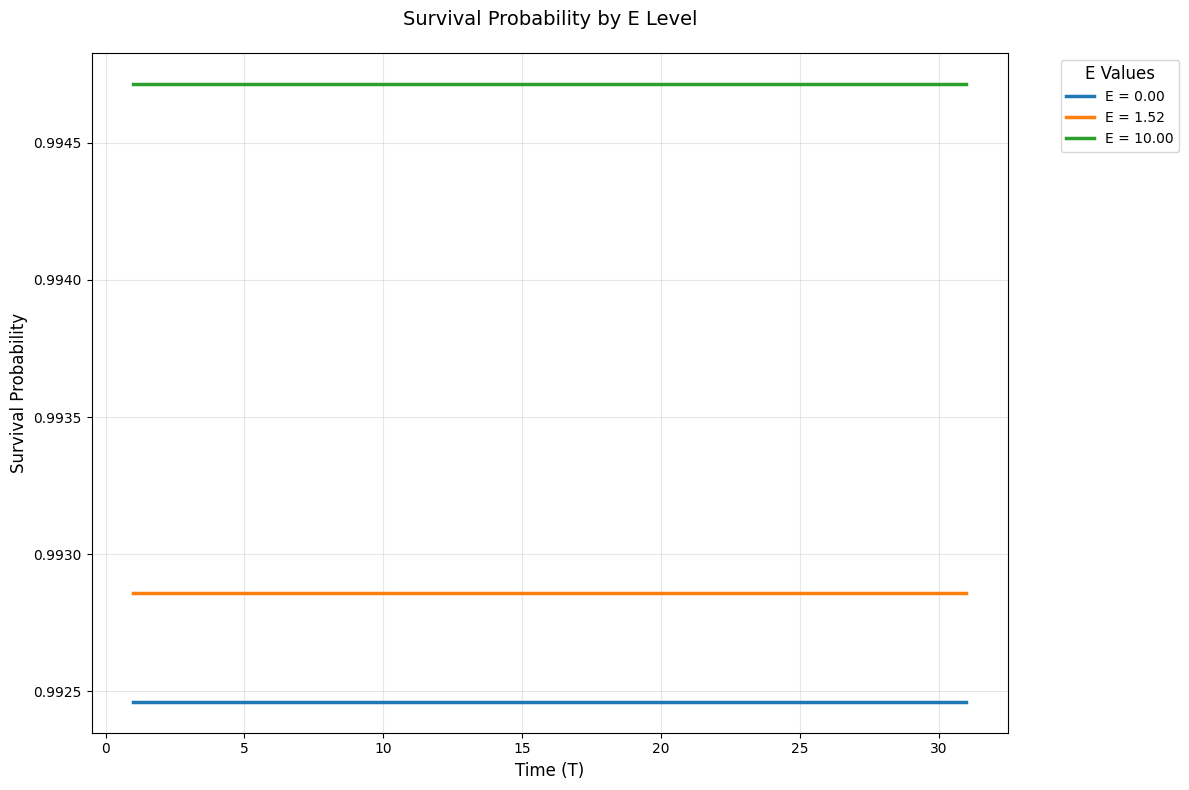

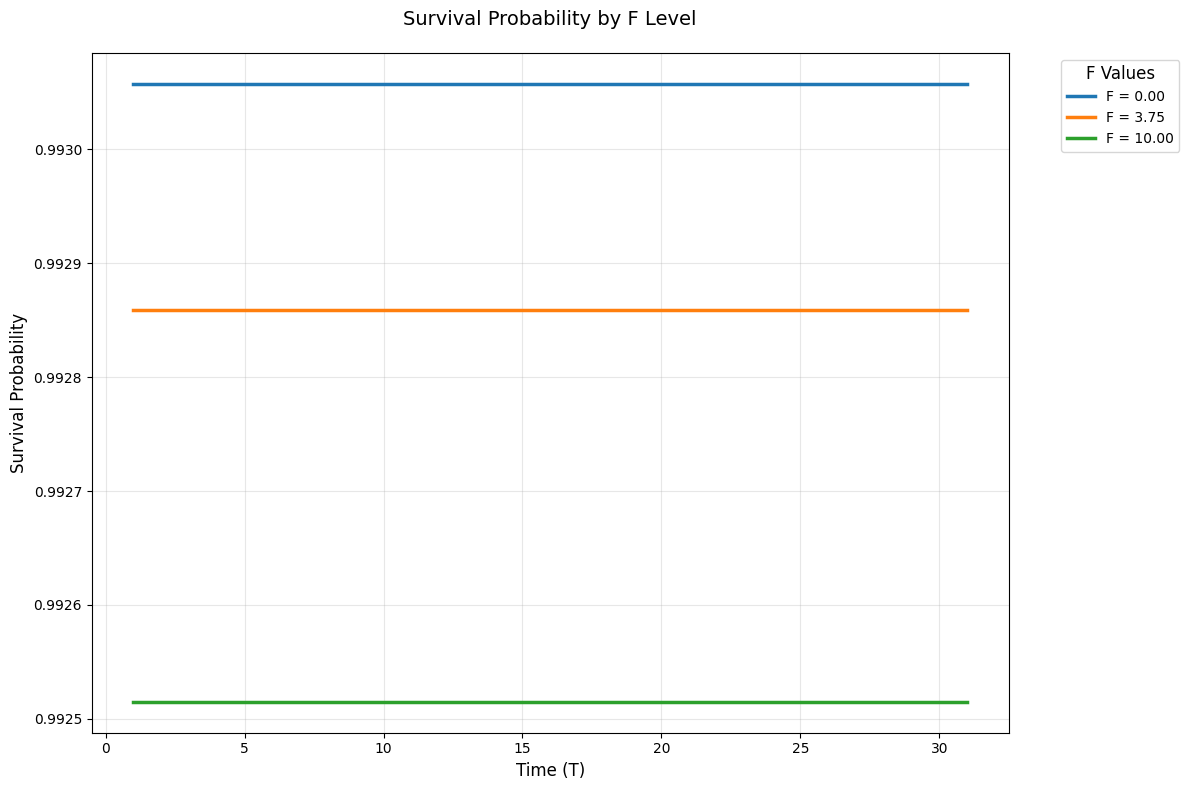

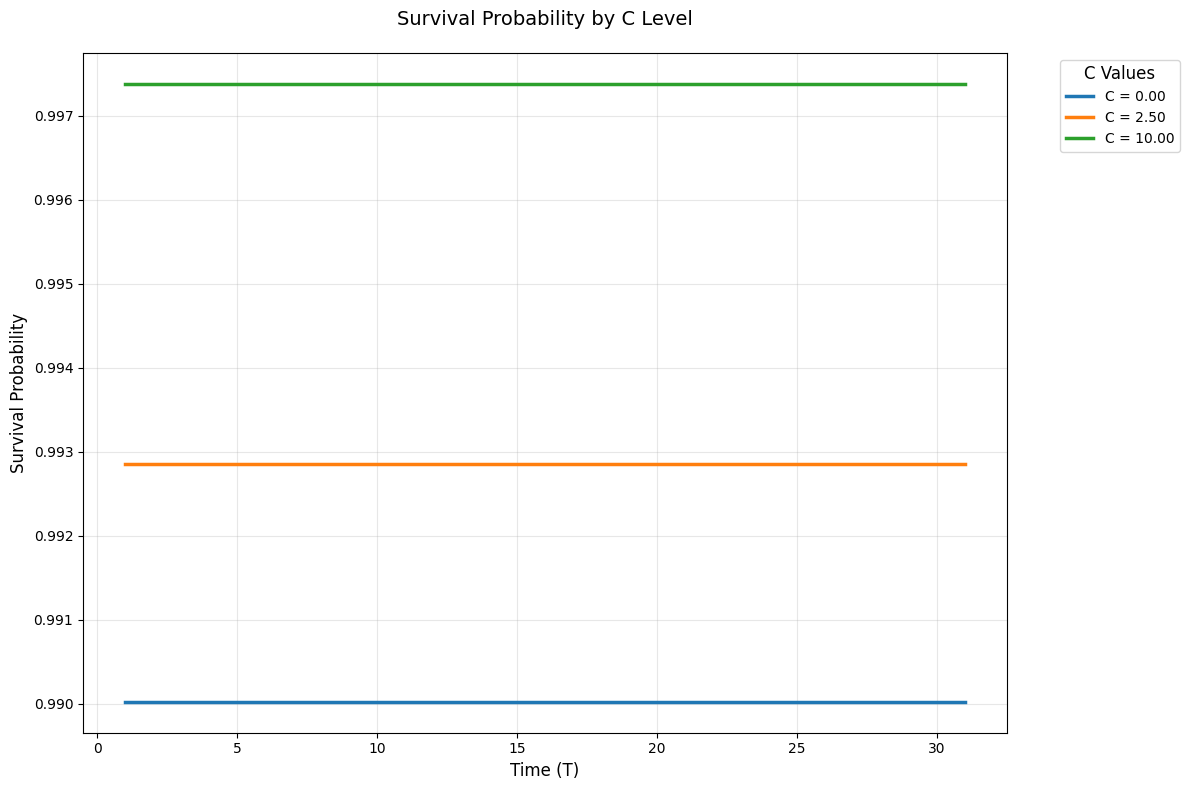


Analysis complete! Plots saved to: reliability_analysis_output\covariate_plots


In [ ]:
# ==================================================
# COVARIATE ANALYSIS
# ==================================================
covariate_plot_dir = Path(OUTPUT_DIR) / "covariate_plots"
os.makedirs(covariate_plot_dir, exist_ok=True)

print("\n7. Running final covariate analysis...")

# 1. Prepare and scale data
covariate_data = data.copy()
covariate_data['C'] = covariate_data['C'] + 0.001  # Handle zeros

# Scale covariates to 0-10 range for better interpretation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))
for col in ['E', 'F', 'C']:
    covariate_data[col] = scaler.fit_transform(covariate_data[[col]])

# 2. Fit model with clean output
aft_model = WeibullAFTFitter(penalizer=0.1)
print("\nFitting model...")
aft_model.fit(covariate_data[['T', 'FC', 'E', 'F', 'C']],
             duration_col='T',
             event_col='FC',
             show_progress=False)

# 3. Display formatted results
print("\n" + "="*60)
print("WEIBULL AFT MODEL SUMMARY".center(60))
print("="*60)
print(aft_model.print_summary(decimals=4, style="ascii"))

# 4. Enhanced interpretation
print("\n" + "PRACTICAL INTERPRETATION".center(60))
print("="*60)

# Get coefficients in a robust way
covariates = ['E', 'F', 'C']
params_dict = aft_model.params_.to_dict()

effect_thresholds = [
    (2.0, "VERY STRONG increase"),
    (1.0, "Strong increase"),
    (0.5, "Moderate increase"),
    (0.2, "Weak increase"),
    (-0.2, "Weak decrease"),
    (-0.5, "Moderate decrease"),
    (-1.0, "Strong decrease"),
    (-2.0, "VERY STRONG decrease")
]

for covar in covariates:
    # Find matching parameter (handles different naming conventions)
    param_name = next((k for k in params_dict.keys() if covar in k), None)
    
    if param_name is None:
        print(f"\nNo parameter found for {covar}")
        continue
        
    coef = params_dict[param_name]
    hr = np.exp(coef)
    
    # Find appropriate effect description
    effect = "Minimal effect"
    for threshold, desc in effect_thresholds:
        if coef >= threshold:
            effect = desc
            break
        if coef <= -threshold:
            effect = desc.replace("increase", "decrease")
            break
    
    print(f"\n{covar} (Coefficient: {coef:.4f}, Hazard Ratio: {hr:.4f})")
    print(f"- Effect: {effect} in failure risk")
    print(f"- Interpretation: A 1-unit increase in scaled {covar}")
    print(f"  corresponds to a {hr:.1f}x change in failure hazard")

# 5. Visualize covariate effects - WORKING VERSION
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

print("\nGenerating covariate effect plots...")
for covar in ['E', 'F', 'C']:
    plt.figure(figsize=(12, 8))  # Increased figure size
    
    # Get typical values (min, median, max)
    vals = [
        covariate_data[covar].min(),
        covariate_data[covar].median(),
        covariate_data[covar].max()
    ]
    
    # Create baseline dataframe with all covariates at median
    baseline_values = covariate_data[['E', 'F', 'C']].median()
    baseline_df = pd.DataFrame({
        'T': time_points,
        'E': baseline_values['E'],
        'F': baseline_values['F'],
        'C': baseline_values['C'],
        'FC': 1  # Event indicator
    })
    
    # Plot survival curves for each value
    for val in vals:
        plot_df = baseline_df.copy()
        plot_df[covar] = val  # Override just this covariate
        
        surv = aft_model.predict_survival_function(plot_df, times=time_points)
        # Correct reshaping of survival probabilities
        plt.plot(time_points, surv.iloc[0, :].values,  # Use iloc[0,:] to get first row
                linewidth=2.5,
                label=f'{covar} = {val:.2f}')
    
    plt.title(f"Survival Probability by {covar} Level", fontsize=14, pad=20)
    plt.xlabel('Time (T)', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    
    # Improved legend
    plt.legend(
        title=f'{covar} Values',
        title_fontsize='large',
        fontsize='medium',
        framealpha=0.8,
        bbox_to_anchor=(1.05, 1),  # Move legend outside plot
        loc='upper left'
    )
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Save and show
    plot_path = covariate_plot_dir / f"{covar}_effect.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')  # Higher DPI
    plt.show()
    plt.close()

print("\nAnalysis complete! Plots saved to:", covariate_plot_dir)

### Interpretation

Survival Probability by (E, F, C)
- The relative effect of each covariate appears to remain constant over time
- The magnitude of each covariate's effect is shown in the plots
- C appears to be the most impactful

> Question I had: Why does DW3(F) provide a better global fit despite C appearing to be most impactful to the results?
- For C, based on the above plots, higher values of C indicate higher survival probabilities. 

- **AIC/BIC**: measures overall model quality (goodness-of-fit + penalty for complexity). DW3 (F) may explain more variance in failure times across all units with fewer parameters
- **Weibull AFT Coefficient**: effect of a specific covariant on survival time. The result we had found that C may have a stronger marginal effect on individual failure times, even if it doesn't improve overall fit as much. The Weibull AFT models the log of survival time as a linear function of covariates.

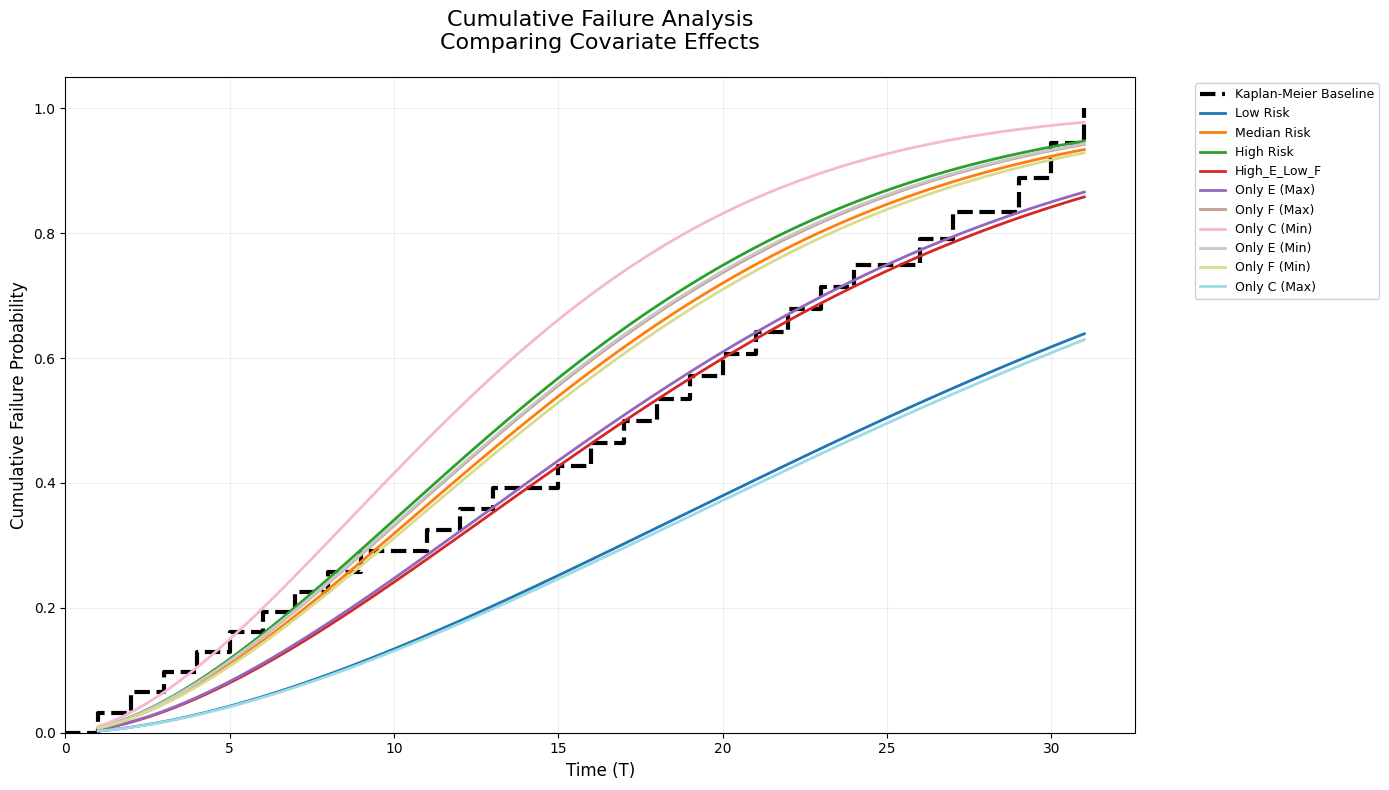

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter, KaplanMeierFitter
from pathlib import Path

# =============================================
# 1. SETUP DATA AND MODEL
# =============================================
# Assuming covariate_data and aft_model are already defined
time_points = np.linspace(covariate_data['T'].min(), covariate_data['T'].max(), 100)
median_values = covariate_data[['E', 'F', 'C']].median()

# =============================================
# 2. DEFINE TEST CASES (NOW INCLUDING SINGLE COVARIATES)
# =============================================
covariate_combinations = {
    # Original combination tests
    "Low Risk": {'E': covariate_data['E'].min(), 'F': covariate_data['F'].min(), 'C': covariate_data['C'].max()},
    "Median Risk": median_values.to_dict(),
    "High Risk": {'E': covariate_data['E'].max(), 'F': covariate_data['F'].max(), 'C': covariate_data['C'].min()},
    "High_E_Low_F": {'E': covariate_data['E'].max(), 'F': covariate_data['F'].min(), 'C': median_values['C']},
    
    # NEW: Individual covariate tests (others at median)
    "Only E (Max)": {**median_values, 'E': covariate_data['E'].max()},
    "Only F (Max)": {**median_values, 'F': covariate_data['F'].max()},
    "Only C (Min)": {**median_values, 'C': covariate_data['C'].min()},
    
    # Add more as needed
    "Only E (Min)": {**median_values, 'E': covariate_data['E'].min()},
    "Only F (Min)": {**median_values, 'F': covariate_data['F'].min()},
    "Only C (Max)": {**median_values, 'C': covariate_data['C'].max()},
}

# =============================================
# 3. GENERATE PLOTS WITH CLEANER VISUALIZATION
# =============================================
plt.figure(figsize=(14, 8))

# Color scheme for better distinction
colors = plt.cm.tab20(np.linspace(0, 1, len(covariate_combinations)))

# Kaplan-Meier baseline
kmf = KaplanMeierFitter()
kmf.fit(covariate_data['T'], covariate_data['FC'])
kmf.plot_cumulative_density(label='Kaplan-Meier Baseline', ci_show=False, 
                          color='black', linewidth=3, linestyle='--')

# Plot each combination
for (name, combo), color in zip(covariate_combinations.items(), colors):
    plot_df = pd.DataFrame({
        'T': time_points,
        'E': combo['E'],
        'F': combo['F'],
        'C': combo['C'],
        'FC': 1
    })
    
    surv = aft_model.predict_survival_function(plot_df, times=time_points)
    plt.plot(time_points, 1 - surv.values.diagonal(),
            label=name,
            color=color,
            linewidth=2)

# =============================================
# 4. ENHANCED VISUAL FORMATTING
# =============================================
plt.title("Cumulative Failure Analysis\nComparing Covariate Effects", fontsize=16, pad=20)
plt.xlabel('Time (T)', fontsize=12)
plt.ylabel('Cumulative Failure Probability', fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(left=0)

# Organized legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=9, framealpha=0.9)
plt.grid(True, alpha=0.2)

# Save high-quality output
output_dir = Path("output_plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "full_covariate_analysis.png", 
           dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

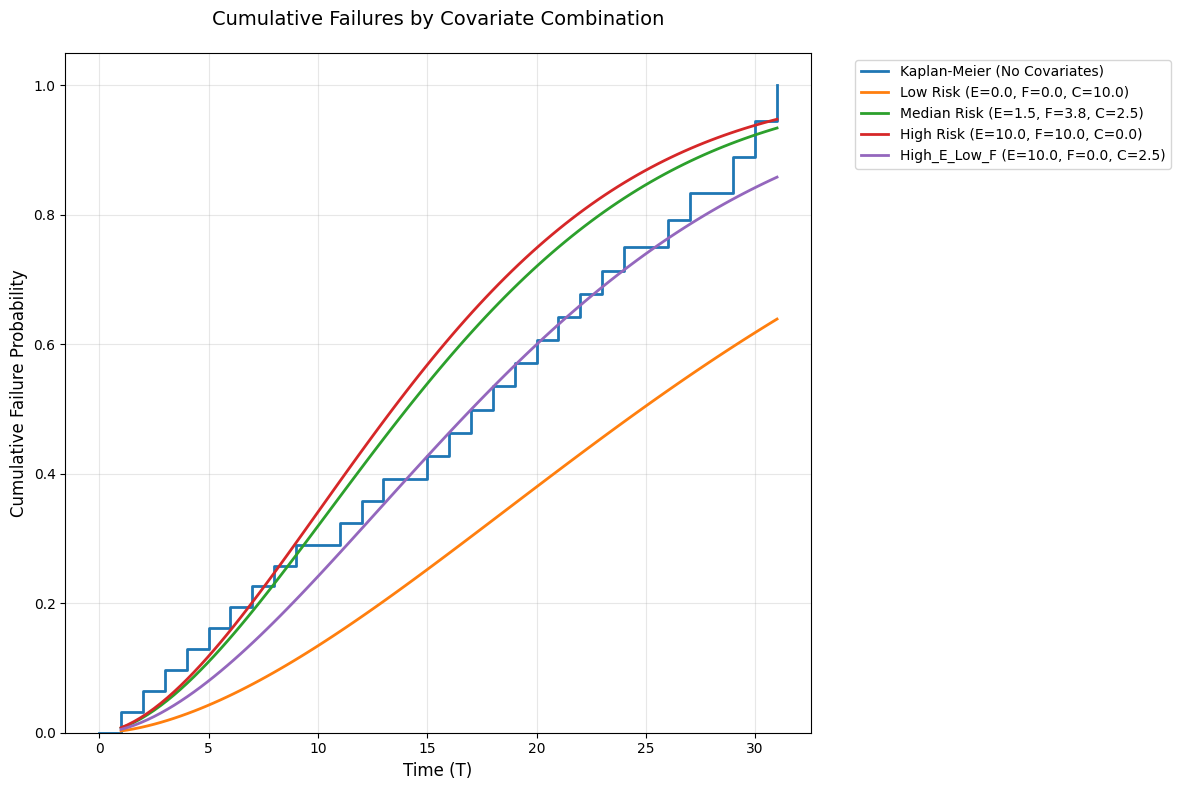

In [12]:
# Time points for evaluation
time_points = np.linspace(covariate_data['T'].min(), covariate_data['T'].max(), 100)

# =============================================
# 1. DEFINE COVARIATE COMBINATIONS TO TEST
# =============================================
# Combinations: (E, F, C) at min/median/max
covariate_combinations = {
    "Low Risk": {
        'E': covariate_data['E'].min(),
        'F': covariate_data['F'].min(),
        'C': covariate_data['C'].max()  # Assuming high C is protective
    },
    "Median Risk": {
        'E': covariate_data['E'].median(),
        'F': covariate_data['F'].median(),
        'C': covariate_data['C'].median()
    },
    "High Risk": {
        'E': covariate_data['E'].max(),
        'F': covariate_data['F'].max(),
        'C': covariate_data['C'].min()
    },
    # Add custom combinations as needed
    "High_E_Low_F": {
        'E': covariate_data['E'].max(),
        'F': covariate_data['F'].min(),
        'C': covariate_data['C'].median()
    }
}

# =============================================
# 2. GENERATE CUMULATIVE FAILURE PLOTS
# =============================================
plt.figure(figsize=(12, 8))

# Plot Kaplan-Meier (baseline, no covariates)
kmf = KaplanMeierFitter()
kmf.fit(covariate_data['T'], covariate_data['FC'])
kmf.plot_cumulative_density(label='Kaplan-Meier (No Covariates)', ci_show=False, linewidth=2)

# Plot Weibull AFT for each combination
for name, combo in covariate_combinations.items():
    # Create a DataFrame with fixed covariate values
    plot_df = pd.DataFrame({
        'T': time_points,
        'E': combo['E'],
        'F': combo['F'],
        'C': combo['C'],
        'FC': 1  # Event indicator
    })
    
    # Predict survival and convert to cumulative failures
    surv = aft_model.predict_survival_function(plot_df, times=time_points)
    cumulative_failures = 1 - surv.values.diagonal()  # Get diagonal values
    
    plt.plot(time_points, cumulative_failures, 
            label=f'{name} (E={combo["E"]:.1f}, F={combo["F"]:.1f}, C={combo["C"]:.1f})',
            linewidth=2)

# =============================================
# 3. FORMAT THE PLOT
# =============================================
plt.title("Cumulative Failures by Covariate Combination", fontsize=14, pad=20)
plt.xlabel('Time (T)', fontsize=12)
plt.ylabel('Cumulative Failure Probability', fontsize=12)
plt.ylim(0, 1.05)

# Legend and grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and show
output_dir = Path("output_plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "covariate_combination_failures.png", dpi=300, bbox_inches='tight')
plt.show()

1. Loading and preparing data...

2. Visualizing original data...


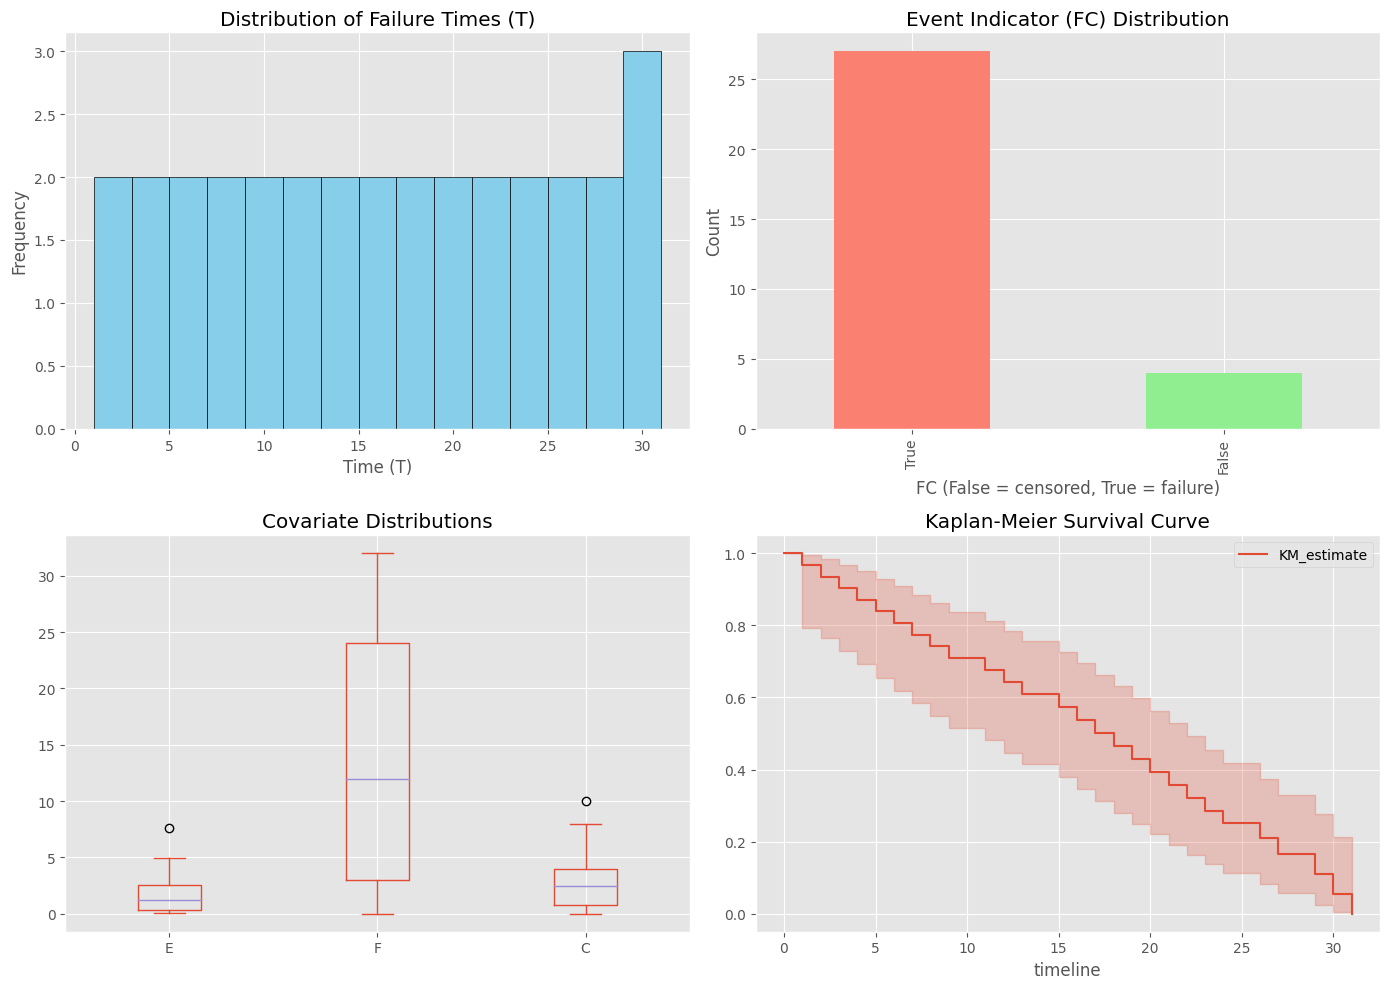


3. Running analysis...

4. Creating model comparison plots...


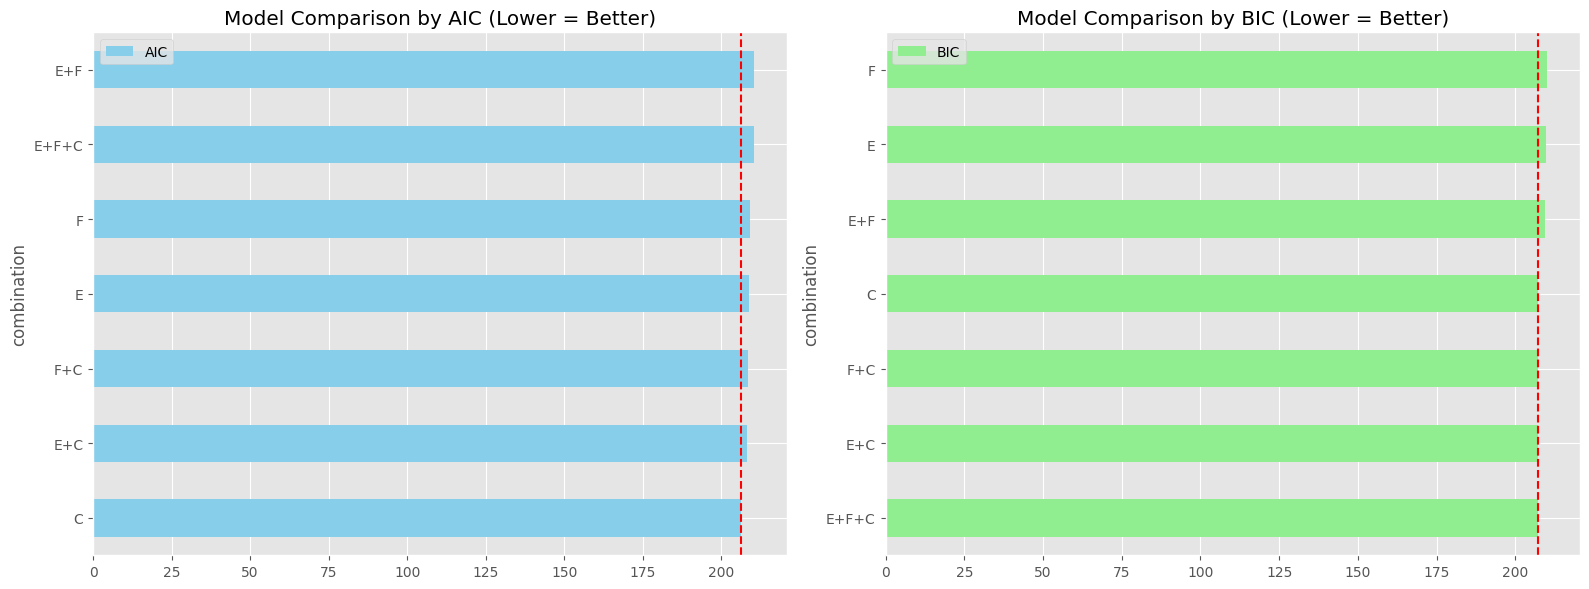


5. Creating survival curves with original data...


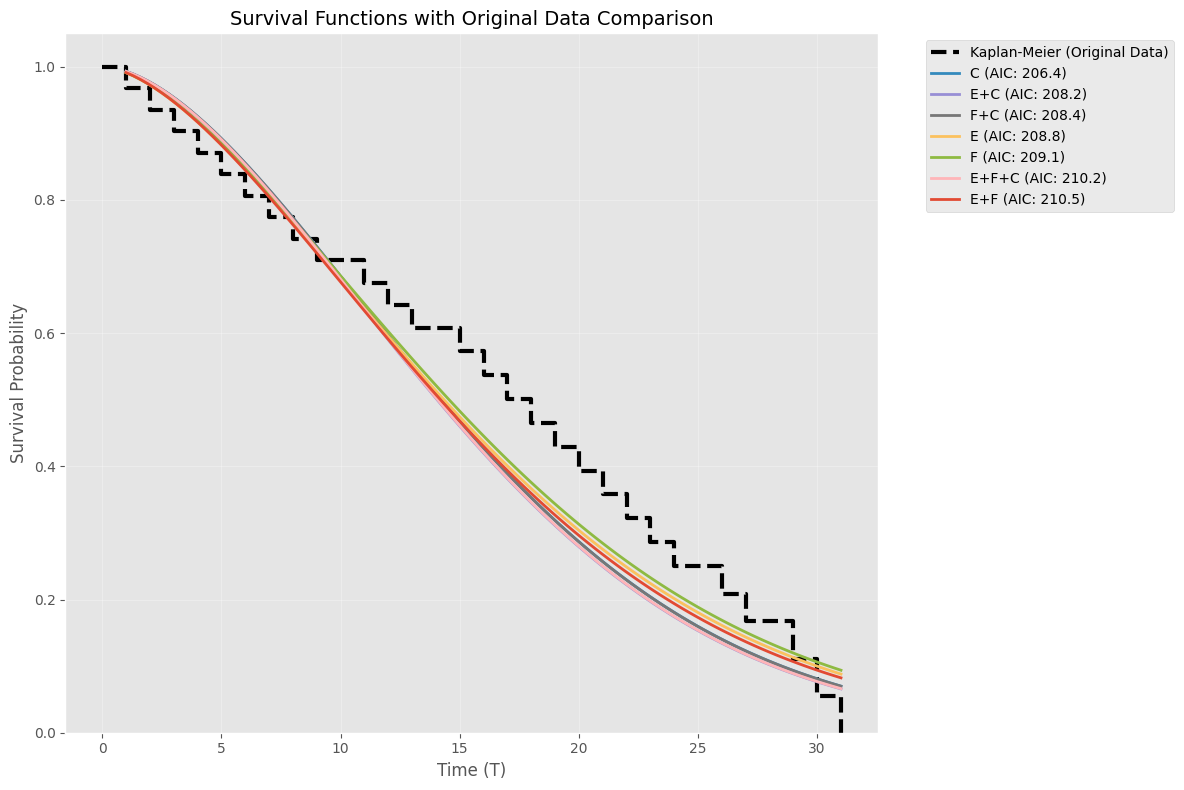


6. Creating cumulative failure curves with original data...


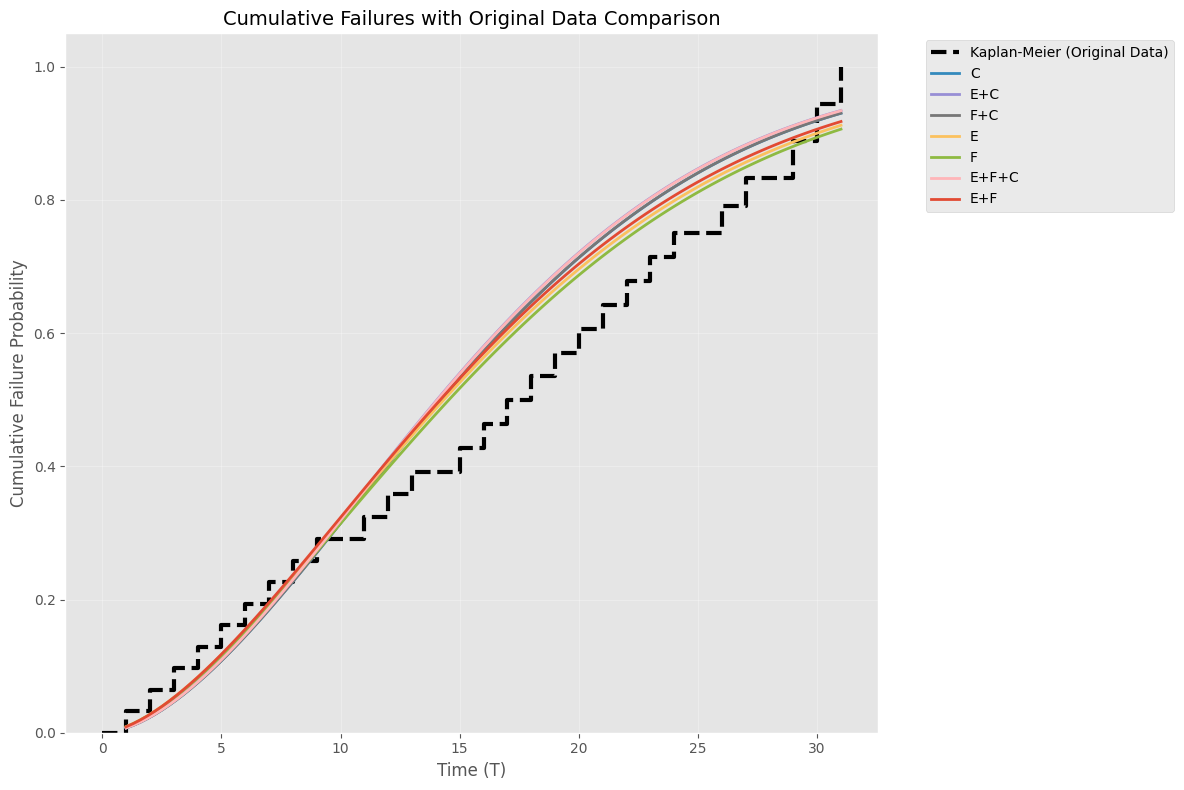


7. Analysis Results:
Top 3 Models:
  combination         AIC         BIC  \
2           C  206.363619  207.231593   
4         E+C  208.224553  207.092527   
5         F+C  208.363184  207.231158   

                                        coefficients  
2  {('lambda_', 'C'): 0.08341973261447187, ('lamb...  
4  {('lambda_', 'C'): 0.07544850115155591, ('lamb...  
5  {('lambda_', 'C'): 0.08291391335499221, ('lamb...  

Best Model: C
AIC: 206.4, BIC: 207.2
Coefficients:
- ('lambda_', 'C'): 0.0834
- ('lambda_', 'Intercept'): 2.6585
- ('rho_', 'Intercept'): 0.5455

All results saved to: reliability_analysis_output


In [13]:
import os
import numpy as np
import pandas as pd
from lifelines import WeibullAFTFitter, KaplanMeierFitter
from itertools import combinations
import matplotlib.pyplot as plt
from pathlib import Path

# ==================================================
# CONFIGURATION
# ==================================================
OUTPUT_DIR = "reliability_analysis_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'  # Ensure white background

# ==================================================
# DATA LOADING AND PREPARATION
# ==================================================
print("1. Loading and preparing data...")
data = pd.read_csv("failure-dataset-a5.csv")
data['FC'] = data['FC'].astype(bool)  # Convert to boolean

# ==================================================
# ORIGINAL DATA VISUALIZATION
# ==================================================
print("\n2. Visualizing original data...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Failure times histogram
axes[0,0].hist(data['T'], bins=15, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Failure Times (T)')
axes[0,0].set_xlabel('Time (T)')
axes[0,0].set_ylabel('Frequency')

# Event indicator bar plot
data['FC'].value_counts().plot(kind='bar', ax=axes[0,1], color=['salmon', 'lightgreen'])
axes[0,1].set_title('Event Indicator (FC) Distribution')
axes[0,1].set_xlabel('FC (False = censored, True = failure)')
axes[0,1].set_ylabel('Count')

# Covariate distributions
data[['E', 'F', 'C']].plot(kind='box', ax=axes[1,0])
axes[1,0].set_title('Covariate Distributions')

# Kaplan-Meier curve
kmf = KaplanMeierFitter()
kmf.fit(data['T'], data['FC'])
kmf.plot_survival_function(ax=axes[1,1])
axes[1,1].set_title('Kaplan-Meier Survival Curve')

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "original_data_visualization.png", dpi=300)
plt.show()

# ==================================================
# MODEL TESTING FUNCTION
# ==================================================
def test_covariate_combinations(data):
    """Test all combinations of covariates E, F, C"""
    covariates = ['E', 'F', 'C']
    results = []
    
    for r in range(1, len(covariates)+1):
        for combo in combinations(covariates, r):
            combo = list(combo)
            aft = WeibullAFTFitter(penalizer=0.1)
            try:
                aft.fit(data[['T', 'FC'] + combo], 
                       duration_col='T', 
                       event_col='FC')
                
                results.append({
                    'combination': '+'.join(combo),
                    'AIC': aft.AIC_,
                    'BIC': aft.BIC_,
                    'coefficients': aft.params_.to_dict()
                })
            except Exception as e:
                print(f"Failed to fit {combo}: {str(e)}")
                continue
    
    return pd.DataFrame(results).sort_values('AIC')

# ==================================================
# MAIN ANALYSIS
# ==================================================
print("\n3. Running analysis...")
model_results = test_covariate_combinations(data)
model_results.to_csv(Path(OUTPUT_DIR) / "model_results.csv", index=False)

# ==================================================
# VISUALIZATION - MODEL COMPARISON
# ==================================================
print("\n4. Creating model comparison plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# AIC Plot
model_results.sort_values('AIC').plot.barh(
    x='combination', y='AIC', ax=ax1, color='skyblue',
    title='Model Comparison by AIC (Lower = Better)'
)
ax1.axvline(x=model_results['AIC'].min(), color='red', linestyle='--')

# BIC Plot
model_results.sort_values('BIC').plot.barh(
    x='combination', y='BIC', ax=ax2, color='lightgreen',
    title='Model Comparison by BIC (Lower = Better)'
)
ax2.axvline(x=model_results['BIC'].min(), color='red', linestyle='--')

plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "model_comparison.png", dpi=300)
plt.show()

# ==================================================
# VISUALIZATION - SURVIVAL CURVES
# ==================================================
print("\n5. Creating survival curves with original data...")
plt.figure(figsize=(12, 8))
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

# First plot Kaplan-Meier (original data)
kmf = KaplanMeierFitter()
kmf.fit(data['T'], data['FC'])
kmf.plot_survival_function(ax=plt.gca(), ci_show=False, label='Kaplan-Meier (Original Data)',
                         linewidth=3, color='black', linestyle='--')

# Then plot all model curves
for _, row in model_results.iterrows():
    combo = row['combination'].split('+')
    aft = WeibullAFTFitter(penalizer=0.1)
    aft.fit(data[['T', 'FC'] + combo], duration_col='T', event_col='FC')
    
    pred_df = pd.DataFrame({
        'T': time_points,
        **{cov: data[cov].median() for cov in combo},
        'FC': True
    })
    
    surv = aft.predict_survival_function(pred_df, times=time_points)
    y_values = surv.values.flatten() if surv.shape[1] == 1 else surv.values.mean(axis=1)
    
    plt.plot(time_points, y_values, 
             label=f"{row['combination']} (AIC: {row['AIC']:.1f})",
             linewidth=2)

plt.title("Survival Functions with Original Data Comparison", fontsize=14)
plt.xlabel('Time (T)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "survival_curves_with_original.png", dpi=300, bbox_inches='tight')
plt.show()

# ==================================================
# VISUALIZATION - CUMULATIVE FAILURES
# ==================================================
print("\n6. Creating cumulative failure curves with original data...")
plt.figure(figsize=(12, 8))
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

# First plot Kaplan-Meier cumulative failures (original data)
kmf = KaplanMeierFitter()
kmf.fit(data['T'], data['FC'])
kmf.plot_cumulative_density(ax=plt.gca(), ci_show=False, label='Kaplan-Meier (Original Data)',
                          linewidth=3, color='black', linestyle='--')

# Then plot all model curves
for _, row in model_results.iterrows():
    combo = row['combination'].split('+')
    aft = WeibullAFTFitter(penalizer=0.1)
    aft.fit(data[['T', 'FC'] + combo], duration_col='T', event_col='FC')
    
    pred_df = pd.DataFrame({
        'T': time_points,
        **{cov: data[cov].median() for cov in combo},
        'FC': True
    })
    
    surv = aft.predict_survival_function(pred_df, times=time_points)
    cumulative_failures = 1 - surv.values.flatten() if surv.shape[1] == 1 else 1 - surv.values.mean(axis=1)
    
    plt.plot(time_points, cumulative_failures, 
             label=f"{row['combination']}",
             linewidth=2)

plt.title("Cumulative Failures with Original Data Comparison", fontsize=14)
plt.xlabel('Time (T)', fontsize=12)
plt.ylabel('Cumulative Failure Probability', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "cumulative_failures_with_original.png", dpi=300, bbox_inches='tight')
plt.show()

# ==================================================
# RESULTS SUMMARY
# ==================================================
print("\n7. Analysis Results:")
print("Top 3 Models:")
print(model_results.head(3))

best_model = model_results.iloc[0]
print(f"\nBest Model: {best_model['combination']}")
print(f"AIC: {best_model['AIC']:.1f}, BIC: {best_model['BIC']:.1f}")
print("Coefficients:")
for param, val in best_model['coefficients'].items():
    print(f"- {param}: {val:.4f}")

print(f"\nAll results saved to: {OUTPUT_DIR}")


7. Creating magnitude comparison plots...


ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

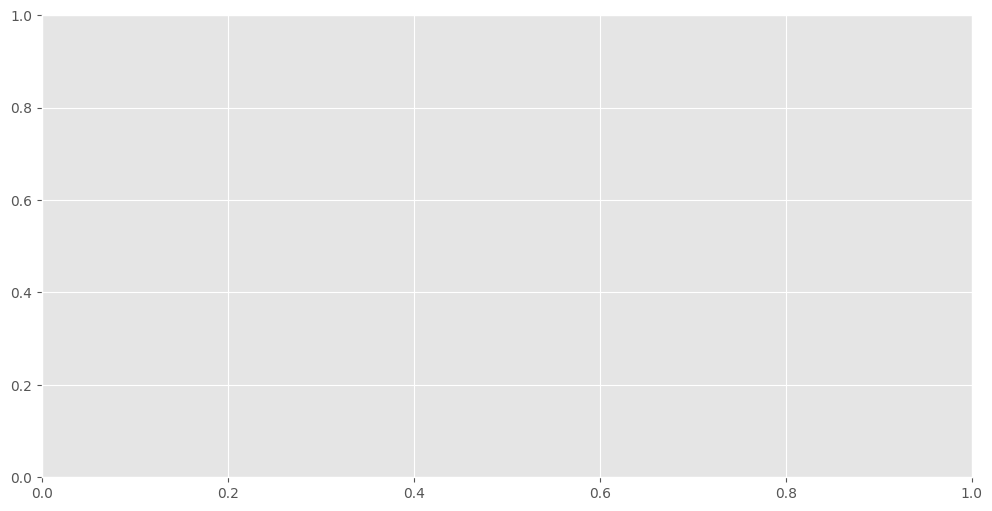

In [ ]:
# ==================================================
# SYSTEMATIC COVARIATE MAGNITUDE COMPARISON (FIXED)
# ==================================================
print("\n7. Creating magnitude comparison plots...")

# Define magnitude levels (low, medium, high)
magnitude_levels = {
    'low': {cov: data[cov].quantile(0.25) for cov in ['E', 'F', 'C']},
    'medium': {cov: data[cov].median() for cov in ['E', 'F', 'C']},
    'high': {cov: data[cov].quantile(0.75) for cov in ['E', 'F', 'C']}
}

# Create time points for prediction
time_points = np.linspace(data['T'].min(), data['T'].max(), 100)

# Create comparison plots for each model
for model_idx, (_, row) in enumerate(model_results.iterrows()):
    combo = row['combination'].split('+')
    plt.figure(figsize=(12, 6))
    
    # Test each magnitude level
    for mag_name, mag_values in magnitude_levels.items():
        # Create prediction dataframe
        pred_df = pd.DataFrame({
            'T': time_points,
            **{cov: mag_values[cov] for cov in combo},
            'FC': True
        })
        
        # Fit and predict
        aft = WeibullAFTFitter(penalizer=0.1)
        aft.fit(data[['T', 'FC'] + combo], duration_col='T', event_col='FC')
        surv = aft.predict_survival_function(pred_df, times=time_points)
        
        # Correctly extract survival probabilities
        if surv.shape[1] == 1:
            y_values = surv.values.flatten()
        else:
            y_values = surv.values.mean(axis=1)  # Average across subjects if multiple
            
        plt.plot(time_points, y_values, 
                 label=f"{mag_name} ({', '.join(f'{cov}={mag_values[cov]:.1f}' for cov in combo)}",
                 linewidth=2,
                 linestyle=['-', '--', ':'][list(magnitude_levels.keys()).index(mag_name)])
    
    plt.title(f"Survival by Magnitude Levels\nModel: {row['combination']} (AIC: {row['AIC']:.1f})", 
              fontsize=12, pad=15)
    plt.xlabel('Time (T)', fontsize=10)
    plt.ylabel('Survival Probability', fontsize=10)
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / f"magnitude_comparison_{row['combination']}.png", 
                dpi=300, bbox_inches='tight')
    plt.close()

# Create combined magnitude plot for top 3 models
print("\n8. Creating combined magnitude comparison for top models...")
plt.figure(figsize=(14, 8))
line_styles = ['-', '--', ':']
top_models = model_results.head(3)

for model_idx, (_, row) in enumerate(top_models.iterrows()):
    combo = row['combination'].split('+')
    
    for mag_idx, (mag_name, mag_values) in enumerate(magnitude_levels.items()):
        pred_df = pd.DataFrame({
            'T': time_points,
            **{cov: mag_values[cov] for cov in combo},
            'FC': True
        })
        
        aft = WeibullAFTFitter(penalizer=0.1)
        aft.fit(data[['T', 'FC'] + combo], duration_col='T', event_col='FC')
        surv = aft.predict_survival_function(pred_df, times=time_points)
        
        # Correctly extract survival probabilities
        y_values = surv.values.flatten() if surv.shape[1] == 1 else surv.values.mean(axis=1)
        
        plt.plot(time_points, y_values,
                 color=plt.cm.tab10(model_idx),
                 linestyle=line_styles[mag_idx],
                 linewidth=2,
                 label=f"{row['combination']} ({mag_name})")

plt.title("Top Models Comparison Across Magnitude Levels", fontsize=14)
plt.xlabel('Time (T)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', lw=2, label='Low (25th percentile)'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Medium (median)'),
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='High (75th percentile)'),
    *[Line2D([0], [0], color=plt.cm.tab10(i), lw=2, 
      label=f"{row['combination']} (AIC: {row['AIC']:.1f})") 
     for i, (_, row) in enumerate(top_models.iterrows())]
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR) / "top_models_magnitude_comparison.png", 
            dpi=300, bbox_inches='tight')
plt.show()